# Task 1: Import Necessary Libraries

In [52]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import numpyro
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

# Task 2: Load the Dataset

In [54]:
data = pd.read_csv("usercode/data.csv")
data.head()

,Date,Sales,adwords_spending,facebookads_spending,awin_spending,tiktok_spending,snapchat_spending
0,2021-01-08,26865.0,3426.0,1861.0,1287.0,1432.0,1532.0
1,2021-01-15,22850.0,2912.0,1919.0,1022.0,1278.0,1682.0
2,2021-01-22,32856.0,5150.0,4161.0,1123.0,1615.0,778.0
3,2021-01-29,35756.0,1416.0,1097.0,1129.0,1284.0,1142.0
4,2021-02-05,29125.0,3093.0,3544.0,817.0,1171.0,1163.0


# Task 3: Explore the Dataset

In [55]:
# check for missing values
data.isna().sum()

Date                    0
Sales                   0
adwords_spending        2
facebookads_spending    2
awin_spending           2
tiktok_spending         2
snapchat_spending       2
dtype: int64

In [56]:
data.describe()

,Sales,adwords_spending,facebookads_spending,awin_spending,tiktok_spending,snapchat_spending
count,156.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,35268.814103,3206.240260,2983.389610,1448.909091,1239.162338,1473.337662
std,6350.950726,1217.082255,1078.147608,510.092474,424.362536,484.917569
min,22077.000000,1378.000000,1070.000000,597.000000,451.000000,600.000000
25%,31925.750000,2133.250000,2032.000000,1017.250000,889.750000,1079.250000
50%,34442.000000,3038.500000,3097.500000,1312.500000,1221.000000,1517.000000
75%,37875.500000,4155.500000,3820.500000,1848.000000,1592.500000,1857.750000
max,72194.000000,6024.000000,5691.000000,3207.000000,2753.000000,2574.000000


In [57]:
correlation_matrix = data.corr(numeric_only=True).round(2)
correlation_matrix

,Sales,adwords_spending,facebookads_spending,awin_spending,tiktok_spending,snapchat_spending
Sales,1.00,0.13,0.13,0.35,0.46,0.33
adwords_spending,0.13,1.00,0.10,0.11,0.06,0.00
facebookads_spending,0.13,0.10,1.00,-0.04,0.17,0.10
awin_spending,0.35,0.11,-0.04,1.00,0.16,0.19
tiktok_spending,0.46,0.06,0.17,0.16,1.00,0.10
snapchat_spending,0.33,0.00,0.10,0.19,0.10,1.00


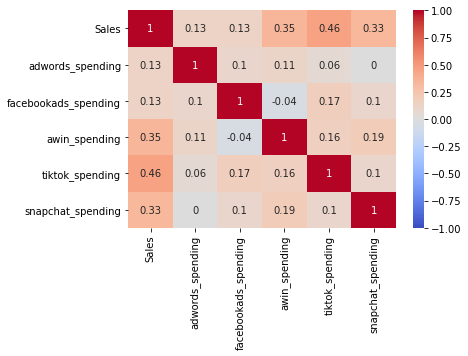

In [58]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

<AxesSubplot: xlabel='Date'>

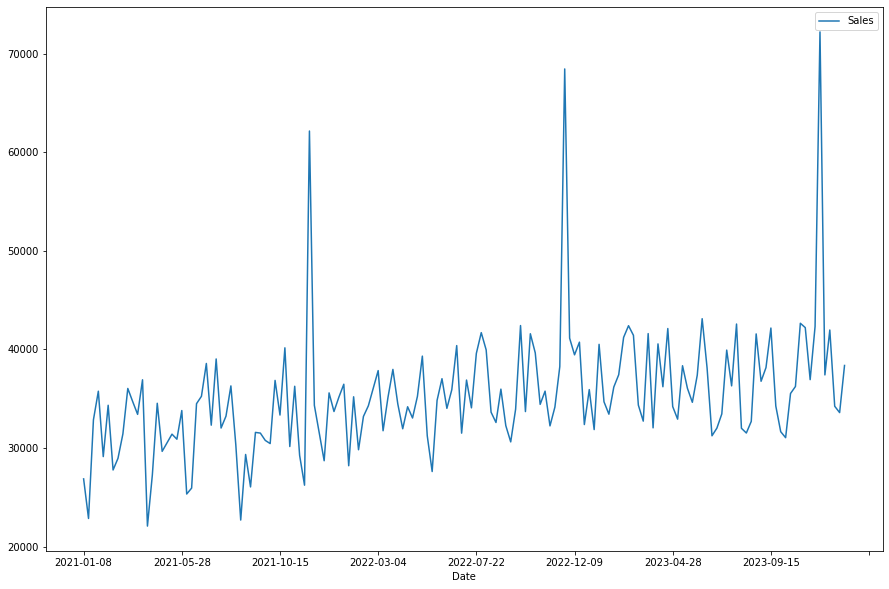

In [59]:
data.plot.line(x="Date", y="Sales", figsize=(15, 10))

# Task 4: Preprocess the Data

In [60]:
data["Date"] = pd.to_datetime(data["Date"])

In [61]:
black_friday_dates = [
    pd.Timestamp('2021-11-26'),
    pd.Timestamp('2022-11-25'),
    pd.Timestamp('2023-11-24')
]

data["black_friday"] = data["Date"].isin(black_friday_dates).astype(int)

In [62]:
data.fillna(0, inplace=True)

In [63]:
n = data.shape[0]
split_point = int(n*0.8)
train = data[:split_point]
test = data[split_point:]

In [64]:
media = ["adwords_spending", "facebookads_spending", "awin_spending", "tiktok_spending", "snapchat_spending"]
extra_features = ["black_friday"]
target = ["Sales"]
costs = np.ones(5)

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

extra_feature_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

scaled_costs = cost_scaler.fit_transform(np.array(costs))

scaled_media_train = media_scaler.fit_transform(train[media].to_numpy())

scaled_extra_features_train = extra_feature_scaler.fit_transform(train[extra_features].to_numpy())

scaled_target_train = target_scaler.fit_transform(train[target].to_numpy())

scaled_media_test = media_scaler.transform(test[media].to_numpy())
scaled_extra_features_test = extra_feature_scaler.transform(test[extra_features].to_numpy())

scaled_target_test = target_scaler.transform(test[target].to_numpy())

# Task 5: Train a Marketing Mix Model

In [65]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

In [66]:
mmm.fit(media=scaled_media_train,
extra_features=scaled_extra_features_train,
    media_prior=scaled_costs,
    target=scaled_target_train,
    number_warmup=100,
    number_samples=300,
    number_chains=1)

sample: 100%|██████████| 400/400 [01:12<00:00,  5.51it/s, 1023 steps of size 6.53e-03. acc. prob=0.79]


# Task 6: Check for Convergence

In [67]:
# Print the model summary
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.37      0.04      0.37      0.31      0.44      2.97      2.11
ad_effect_retention_rate[1]      0.37      0.04      0.37      0.30      0.44      8.63      1.17
ad_effect_retention_rate[2]      0.46      0.10      0.43      0.34      0.62      2.52      2.72
ad_effect_retention_rate[3]      0.67      0.18      0.74      0.40      0.91      2.45      3.32
ad_effect_retention_rate[4]      0.62      0.10      0.64      0.47      0.75      3.32      1.71
     coef_extra_features[0]      0.00      0.00      0.00     -0.00      0.00    229.39      1.00
              coef_media[0]      0.01      0.01      0.00      0.00      0.01     55.93      1.00
              coef_media[1]      0.00      0.00      0.00      0.00      0.01    106.14      1.00
              coef_media[2]      0.00      0.00      0.00      0.00      0.01     62.80      1.03
              coef_

# Task 7: Evaluate the Model

In [68]:
# Use the model to get predictions for the test set
prediction=mmm.predict(
        media=test[media].to_numpy(),
        extra_features=test[extra_features].to_numpy(),
        target_scaler=target_scaler
    )

In [69]:
# Get the mean value of those predictions for each data point
prediction_mean=np.mean(prediction,axis=0)

In [70]:
# Calculate and print the RMSE
rmse=np.sqrt(
    np.mean(pow(test["Sales"]-prediction_mean , 2))
)
print(rmse)

916365.4


# Task 8: Check for Prediction Quality

In [71]:
# Extract the average and range of predictions
avg_predictions = np.mean(prediction, axis=0)
std_dev_predictions = np.std(prediction, axis=0)
range_predictions = std_dev_predictions*2

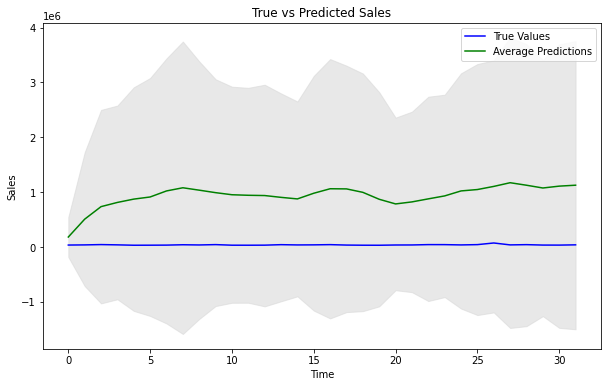

In [72]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
  test["Sales"].reset_index(drop=True),
  label="True Values", color='blue')
plt.plot(
  avg_predictions,
  label="Average Predictions",
  color='green')
plt.fill_between(
  range(len(avg_predictions)),
  avg_predictions - range_predictions,
  avg_predictions + range_predictions,
  color='lightgrey', alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Sales")
plt.title("True vs Predicted Sales")
plt.legend()
plt.show()

# Task 9: Check Parameter Estimations

In [73]:
# Plot media channel priors vs. posteriors

In [74]:
# Plot the media baseline contributions

# Task 10: Assess Model Insights

In [75]:
# Get the estimators for media effect and ROI

In [76]:
# Calculate and print their mean values

# Task 11: Optimize Media Spending

In [77]:
# Define a time frame and a budget

# Run media optimization

# Task 12: Persist the Model

In [78]:
# Save the model

In [ ]:
# Load the model and print its summary

In [ ]:
# Use the model to make predictions on the test set